<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/gan_mog_mode_hopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture of Gaussians example with GANs

This code was adapted from the ODEGAN code here: 
https://github.com/deepmind/deepmind-research/blob/master/ode_gan/odegan_mog16.ipynb

**The original colab was created by Chongli Qin**‎. Adapted by Mihaela Rosca.


# **This code implements GANs for Mixture of Gaussians.**

It also provides an implementation of ODEGAN (Training Generative Adversarial Networks by Solving Ordinary Differential Equations by Qin et al.)

The approach of ODE-GAN was mentioned in the book as using higer order integrators such as RungeKutta4.

In [1]:
!pip install dm-haiku

     |████████████████████████████████| 284 kB 5.7 MB/s 


In [2]:
import functools

import haiku as hk

# @title Imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from jax import lax

In [3]:
# @title An MLP Haiku Module


class MLP(hk.Module):
    def __init__(self, depth, hidden_size, out_dim, name="SimpleNet"):
        super(MLP, self).__init__(name=name)
        self._depth = depth
        self._hidden_size = hidden_size
        self._out_dim = out_dim
        layers = []
        for i in range(self._depth):
            layers.append(hk.Linear(self._hidden_size, name="linear_%d" % (i)))
        self._layers = layers
        self._final_layer = hk.Linear(self._out_dim, name="final_layer")

    def __call__(self, input):
        h = input
        for i in range(self._depth):
            h = jax.nn.relu(self._layers[i](h))
        return self._final_layer(h)

In [4]:
# @title Real Data
def real_data(batch_size):
    mog_mean = np.array(
        [
            [1.50, 1.50],
            [1.50, 0.50],
            [1.50, -0.50],
            [1.50, -1.50],
            [0.50, 1.50],
            [0.50, 0.50],
            [0.50, -0.50],
            [0.50, -1.50],
            [-1.50, 1.50],
            [-1.50, 0.50],
            [-1.50, -0.50],
            [-1.50, -1.50],
            [-0.50, 1.50],
            [-0.50, 0.50],
            [-0.50, -0.50],
            [-0.50, -1.50],
        ]
    )
    temp = np.tile(mog_mean, (batch_size // 16 + 1, 1))
    mus = temp[0:batch_size, :]
    return mus + 0.02 * np.random.normal(size=(batch_size, 2))

In [5]:
# @title ODE-integrators
def euler_step(func, y0, f0, t0, dt):
    # Euler update
    y1 = jax.tree_multimap(lambda u, v: dt * v + u, y0, f0)
    return y1


def runge_kutta_step(func, y0, f0, t0, dt):
    # RK4 Butcher tableaux
    alpha = jnp.array([1.0 / 2.0, 1.0 / 2.0, 1.0, 0])
    beta = jnp.array(
        [
            [1.0 / 2.0, 0, 0, 0],
            [0, 1.0 / 2.0, 0, 0],
            [0, 0, 1.0, 0],
        ]
    )
    c_sol = jnp.array([1.0 / 6.0, 1.0 / 3.0, 1.0 / 3.0, 1.0 / 6.0])

    def body_fun(i, k):
        ti = t0 + dt * alpha[i - 1]
        yi = jax.tree_multimap(
            lambda u, v: u + dt * jnp.tensordot(beta[i - 1, :], v, axes=1), y0, k
        )
        ft = func(yi, ti)
        return jax.tree_multimap(lambda x, y: x.at[i, :].set(y), k, ft)

    k = jax.tree_map(lambda f: jnp.zeros((4,) + f.shape, f.dtype).at[0, :].set(f), f0)
    k = lax.fori_loop(1, 4, body_fun, k)

    y1 = jax.tree_multimap(lambda u, v: dt * jnp.tensordot(c_sol, v, axes=1) + u, y0, k)
    return y1

In [6]:
# @title Utility Functions.
def disc_loss(disc_params, gen_params, real_examples, latents):
    fake_examples = gen_model.apply(gen_params, None, latents)
    real_logits = disc_model.apply(disc_params, None, real_examples)
    fake_logits = disc_model.apply(disc_params, None, fake_examples)
    disc_real = real_logits - jax.nn.log_sigmoid(real_logits)
    disc_fake = -jax.nn.log_sigmoid(fake_logits)
    return -jnp.mean(disc_real + disc_fake)


def gen_loss(disc_params, gen_params, real_examples, latents):
    fake_examples = gen_model.apply(gen_params, None, latents)
    fake_logits = disc_model.apply(disc_params, None, fake_examples)
    disc_fake = fake_logits - jax.nn.log_sigmoid(fake_logits)
    return -jnp.mean(disc_fake)


def gen_loss_per_example(disc_params, gen_params, real_examples, latents):
    fake_examples = gen_model.apply(gen_params, None, latents)
    fake_logits = disc_model.apply(disc_params, None, fake_examples)
    disc_fake = fake_logits - jax.nn.log_sigmoid(fake_logits)
    return -disc_fake


def gen_norm_per_example(disc_params, gen_params, real_examples, latents):
    grad = jax.jacfwd(gen_loss_per_example, argnums=1)(
        disc_params, gen_params, real_examples, latents
    )
    flat, _ = jax.tree_flatten(grad)
    norm = jnp.zeros(shape=(latents.shape[0],))
    for a in flat:
        norm += jnp.sum(a * a, axis=np.arange(1, len(a.shape)))
    return -jnp.mean(norm)


def disc_loss_per_example(disc_params, gen_params, real_examples, latents):
    fake_examples = gen_model.apply(gen_params, None, latents)
    real_logits = disc_model.apply(disc_params, None, real_examples)
    fake_logits = disc_model.apply(disc_params, None, fake_examples)
    disc_real = real_logits - jax.nn.log_sigmoid(real_logits)
    disc_fake = -jax.nn.log_sigmoid(fake_logits)
    return -(disc_real + disc_fake)


def disc_norm_per_example(disc_params, gen_params, real_examples, latents):
    grad = jax.jacfwd(disc_loss_per_example, argnums=0)(
        disc_params, gen_params, real_examples, latents
    )
    flat, _ = jax.tree_flatten(grad)
    norm = jnp.zeros(shape=(latents.shape[0],))
    for a in flat:
        norm += jnp.sum(a * a, axis=np.arange(1, len(a.shape)))
    return -jnp.mean(norm)


def gen_norm(disc_params, gen_params, real_examples, latents):
    grad = jax.grad(gen_loss, argnums=1)(
        disc_params, gen_params, real_examples, latents
    )
    flat, _ = jax.tree_flatten(grad)
    norm = 0.0
    for a in flat:
        norm += jnp.sum(a * a)
    return -norm


def get_gen_grad(gen_params, t, disc_params, real_examples, latents):
    return jax.grad(gen_loss, argnums=1)(
        disc_params, gen_params, real_examples, latents
    )


def get_disc_grad(disc_params, t, gen_params, real_examples, latents):
    return jax.grad(disc_loss, argnums=0)(
        disc_params, gen_params, real_examples, latents
    )


def variance_calc(disc_params, gen_params, real_examples, latents):
    neg_var = gen_norm_per_example(disc_params, gen_params, real_examples, latents)
    neg_var -= gen_norm(disc_params, gen_params, real_examples, latents)
    return neg_var

In [7]:
# @title Visualising the data.


def kde(mu, tau, bbox=None, xlabel="", ylabel="", cmap="Blues", st=0):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1] - bbox[0]) / abs(bbox[3] - bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks([])
    ax.set_yticks([])

    xx, yy = np.mgrid[bbox[0] : bbox[1] : 300j, bbox[2] : bbox[3] : 300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    plt.tight_layout()
    # plt.show()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3176: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


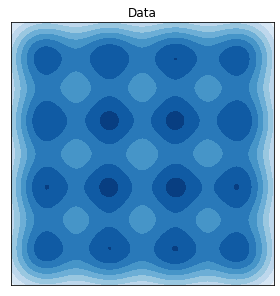

i = 0, discriminant loss = 1.4437454, generator loss = 0.7051276


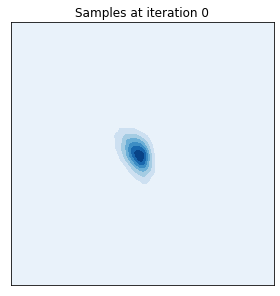

i = 2000, discriminant loss = 1.3250904, generator loss = 0.7357825


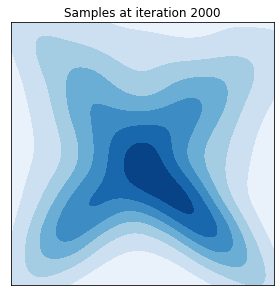

i = 4000, discriminant loss = 1.180843, generator loss = 0.6669865


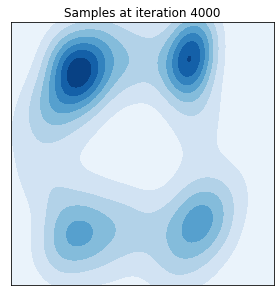

i = 6000, discriminant loss = 0.92390156, generator loss = 0.9136342


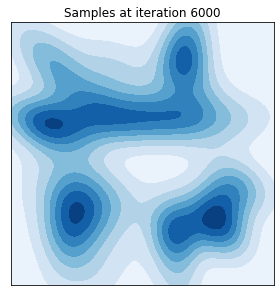

i = 8000, discriminant loss = 0.749205, generator loss = 1.3038869


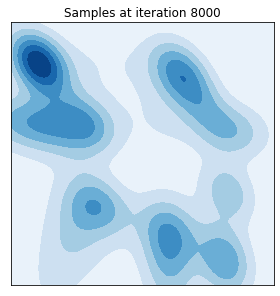

i = 10000, discriminant loss = 0.42861283, generator loss = 2.1997209


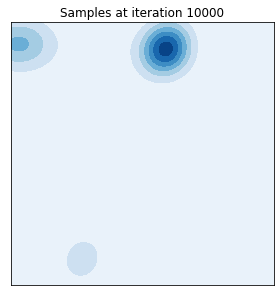

i = 12000, discriminant loss = 0.36093917, generator loss = 1.8330802


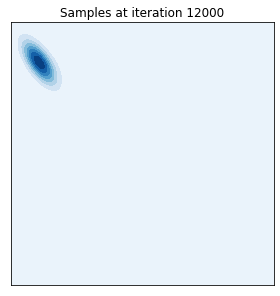

i = 14000, discriminant loss = 0.2848192, generator loss = 3.4266524


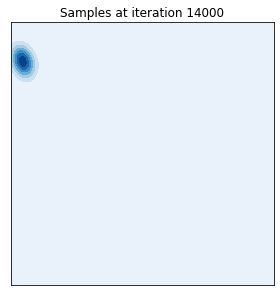

i = 16000, discriminant loss = 0.5816947, generator loss = 1.5565174


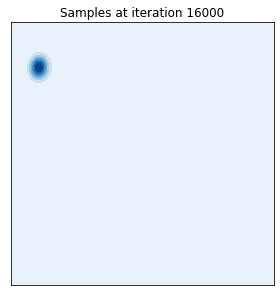

i = 18000, discriminant loss = 0.48241615, generator loss = 1.6872962


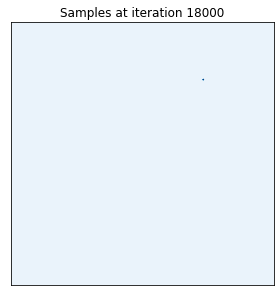

i = 20000, discriminant loss = 0.9360501, generator loss = 1.2079774


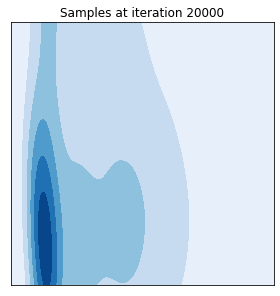

In [8]:
# @title Integration
n_itrs = 20001  # @param {type : 'integer'}
n_save = 2000  # @param {type : 'integer'}
latent_size = 32  # @param {type : 'integer'}
bs = 512  # @param {type : 'integer'}
odeint = "euler_step"  # @param ['euler_step', 'euler_heun_step', 'runge_kutta_step'] {type : 'string'}
delta_t = 0.05  # @param {type : 'number'}
reg_param = 0.0  # @param {type : 'number'}
t = 0.0


def forward_disc(batch):
    disc_model = MLP(2, 25, 1)
    return disc_model(batch)


def forward_gen(batch):
    gen_model = MLP(2, 25, 2)
    return gen_model(batch)


disc_model = hk.transform(forward_disc)
gen_model = hk.transform(forward_gen)
real_examples = real_data(bs)

ODEINT = {"runge_kutta_step": runge_kutta_step, "euler_step": euler_step}


@jax.jit
def ode_update(i, disc_params, gen_params, real_examples, latents):
    dloss, disc_grad = jax.value_and_grad(disc_loss, argnums=0)(
        disc_params, gen_params, real_examples, latents
    )
    gloss, gen_grad = jax.value_and_grad(gen_loss, argnums=1)(
        disc_params, gen_params, real_examples, latents
    )
    variance, disc_gen_grad = jax.value_and_grad(variance_calc)(
        disc_params, gen_params, real_examples, latents
    )
    norms_per_example, _ = jax.value_and_grad(gen_norm_per_example, argnums=0)(
        disc_params, gen_params, real_examples, latents
    )
    discnorm, gen_disc_grad = jax.value_and_grad(disc_norm_per_example, argnums=1)(
        disc_params, gen_params, real_examples, latents
    )
    norms, _ = jax.value_and_grad(gen_norm, argnums=0)(
        disc_params, gen_params, real_examples, latents
    )
    grad_disc_fn = functools.partial(
        get_disc_grad,
        **{
            "gen_params": gen_params,
            "real_examples": real_examples,
            "latents": latents,
        },
    )
    grad_gen_fn = functools.partial(
        get_gen_grad,
        **{
            "disc_params": disc_params,
            "real_examples": real_examples,
            "latents": latents,
        },
    )
    new_gen_params = ODEINT[odeint](grad_gen_fn, gen_params, gen_grad, 0.0, delta_t)
    new_disc_params = ODEINT[odeint](grad_disc_fn, disc_params, disc_grad, 0.0, delta_t)
    new_disc_params = jax.tree_multimap(
        lambda x, y: x + delta_t * reg_param * y, new_disc_params, disc_gen_grad
    )
    new_gen_params = jax.tree_multimap(
        lambda x, y: x + delta_t * reg_param * y, new_gen_params, gen_disc_grad
    )
    return new_disc_params, new_gen_params, -dloss, -gloss


rng = jax.random.PRNGKey(np.random.randint(low=0, high=int(1e7)))
test_latents = np.random.normal(size=(bs * 10, latent_size))
latents = np.random.normal(size=(bs, latent_size))
disc_params = disc_model.init(rng, real_examples)
gen_params = gen_model.init(
    jax.random.PRNGKey(np.random.randint(low=0, high=int(1e7))), latents
)

x = np.arange(-2.0, 2.0, 0.1)
y = np.arange(-2.0, 2.0, 0.1)
X, Y = np.meshgrid(x, y)
pairs = np.stack((X, Y), axis=-1)
pairs = np.reshape(pairs, (-1, 2))

bbox = [-2, 2, -2, 2]
kde(real_examples[:, 0], real_examples[:, 1], bbox=bbox, st=0)
plt.title("Data")
plt.show()

for e in range(n_itrs):
    real_examples = real_data(bs)
    latents = np.random.normal(size=(bs, latent_size))
    (disc_params, gen_params, dloss, gloss) = ode_update(
        e, disc_params, gen_params, real_examples, latents
    )
    t += delta_t
    if e % n_save == 0:
        print("i = %d, discriminant loss = %s, generator loss = %s" % (e, dloss, gloss))

        fake_examples = gen_model.apply(gen_params, None, test_latents)

        kde(fake_examples[:, 0], fake_examples[:, 1], bbox=bbox, st=e)
        plt.title("Samples at iteration {}".format(e))
        plt.show()